# Lesson 01. Part 2. Quadratic equation

Let's try to build a model that can extrapolate a quadratic equation: ```ax^2 + bx + c```

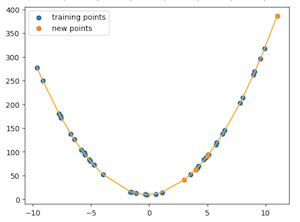

## Preparation

In [2]:
import torch
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [3]:
# get device for training (cpu, cuda or mps)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"{device} device is used")

mps device is used


In [4]:
# display settings
torch.set_printoptions(precision=2, sci_mode=False)

## Sample data

Quadratic equation follows the pattern: ```ax^2 + bx + c```

In [5]:
# equation params for y = kx + b
# BIAS which is greater than zero shifts points so that they do not lie on a straight line
A = 3
B = 1.2
C = 10
BIAS = 3

# calculate y
def generate_data(x, a, b, c, bias=0):
    y = a * x ** 2 + b * x + c + bias * (random.random() - 0.5)
    return y

# settings
input_amount = 40
input_min = -10
input_max = 10

# generation
random.seed(100)         # fix random values (debug only)
torch.manual_seed(100)   # fix random values (debug only)

input_x = torch.rand(input_amount) * (input_max - input_min) + input_min
output_y = input_x.clone().apply_(lambda x: generate_data(x=x, a=A, b=B, c=C, bias=BIAS))

print('input_x =', input_x)
print('output_y =', output_y)

input_x = tensor([-7.77,  6.32, -4.75, -0.32,  3.53,  5.08, -4.75, -9.14, -5.84, -7.64,
        -7.57,  4.71,  4.24,  5.75, -1.63,  8.03,  9.94,  5.13, -5.52, -3.95,
        -6.43,  6.48,  1.11,  9.54, -1.12,  8.96,  4.89, -0.22, -5.15,  4.01,
         0.55, -5.06,  5.82, -1.53, -9.66, -5.58,  9.07,  4.13, -6.74,  7.80])
output_y = tensor([180.58, 137.15,  72.77,  10.54,  52.32,  93.26,  72.78, 249.92, 104.03,
        175.78, 171.30,  83.56,  70.24, 115.65,  15.48, 213.80, 317.31,  94.15,
         93.92,  51.68, 126.76, 145.01,  14.20, 295.88,  12.58, 262.63,  88.55,
          8.86,  83.80,  61.84,  10.10,  80.32, 119.34,  15.39, 277.55,  97.80,
        268.96,  65.29, 138.13, 202.48])


Let's display points on the graph. Based on the BIAS value, they may lie on the same line or be close to it

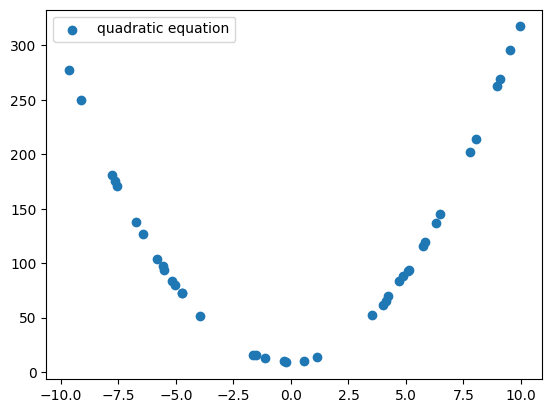

In [6]:
# display input data
# depends on BIAS they will or won't lie on the same line, but still will be very close fo it
plt.scatter(input_x, output_y, label='quadratic equation')
plt.legend()
plt.show()

## Split data into training and validation datasets

As in the [linear equation](https://github.com/RomanPankin/ai-lessons/blob/main/01-equations/01-linear-equation.ipynb), we need 2 datasets:
* training dataset - will be used to train AI
* validation dataset - will be used to train AI at the time of training

In [7]:
# create dataset
dataset = torch.utils.data.TensorDataset(input_x.to(device), output_y.to(device))
print('Dataset length: ', len(dataset))

Dataset length:  40


In [8]:
# settings
training_split_ratio = 0.8

# split
torch.manual_seed(200)   # pseudo random values (debug only)

input_size = len(dataset)
train_size = int(training_split_ratio * input_size)
test_size = input_size - train_size

train_dataset_subset, validation_dataset_subset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Training dataset - {} indices:\n {}".format(len(train_dataset_subset), train_dataset_subset.indices))
print("Validation dataset - {} indices:\n {}".format(len(validation_dataset_subset), validation_dataset_subset.indices))
print("Total: {} items".format(input_size))

Training dataset - 32 indices:
 [2, 26, 28, 32, 1, 37, 4, 12, 33, 19, 11, 38, 29, 9, 0, 24, 3, 27, 8, 5, 35, 31, 13, 39, 10, 20, 23, 14, 21, 16, 36, 7]
Validation dataset - 8 indices:
 [17, 25, 34, 6, 18, 30, 15, 22]
Total: 40 items


**batch_size** is another important setting. Each AI can be trained by receiving data one by one.
Where, basically, we pass a single input and get a single output values. 

However it's more efficient to send multiple input values at the same time and train AI using them all. The size of the input data is specified by the **batch_size** setting.

Batch size is: 32
tensor([-4.75,  4.89, -5.15,  5.82,  6.32,  4.13,  3.53,  4.24, -1.53, -3.95,
         4.71, -6.74,  4.01, -7.64, -7.77, -1.12, -0.32, -0.22, -5.84,  5.08,
        -5.58, -5.06,  5.75,  7.80, -7.57, -6.43,  9.54, -1.63,  6.48,  9.94,
         9.07, -9.14], device='mps:0') tensor([ 72.77,  88.55,  83.80, 119.34, 137.15,  65.29,  52.32,  70.24,  15.39,
         51.68,  83.56, 138.13,  61.84, 175.78, 180.58,  12.58,  10.54,   8.86,
        104.03,  93.26,  97.80,  80.32, 115.65, 202.48, 171.30, 126.76, 295.88,
         15.48, 145.01, 317.31, 268.96, 249.92], device='mps:0')


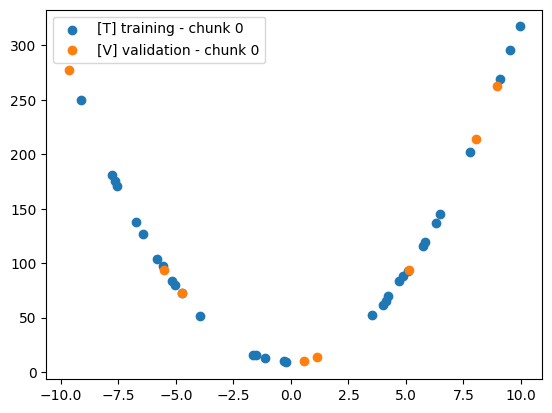

In [9]:
# settings
batch_size = 32
print('Batch size is: {}'.format(batch_size))

# display training dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset_subset, shuffle=False, batch_size=batch_size)
for i, (x,y) in enumerate(train_dataloader):
    print(x, y)
    plt.scatter(x.cpu(), y.cpu(), label='[T] training - chunk {}'.format(i))

# display validation dataset
validation_dataloader = torch.utils.data.DataLoader(validation_dataset_subset, shuffle=False, batch_size=batch_size)
for i, (x,y) in enumerate(validation_dataloader):
    plt.scatter(x.cpu(), y.cpu(), label='[V] validation - chunk {}'.format(i))

plt.legend()
plt.show()

## Training

Let's create the model. A Linear layer won't work for this task. We need a layer which contains 3 parameters: a, b and c; and which understands exponentiation.

There is no such a standard layer, so we need to create it by ourselves

In [10]:
class QuadraticLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        return self.a * x ** 2 + self.b * x + self.c

    def string(self):
        return f'y = {self.a.item()} x^2 + {self.b.item()} x + {self.c.item()}'

In the QuadraticLayer above we added **forward** function which calculates layer result based on the variable ```x``` and hidden input parameters ```a, b, c```

Let's try to train the model

In [11]:
# model params
dim_in, dim_out = 1, 1
rate_learning = 0.01
max_iterations = 10000

early_stop_loss = 0.0000000001
early_stop_max_count = 3

info_interval = 10

# create model
model = torch.nn.Sequential(
    QuadraticLayer()
)
model.to(device)

print(model)

Sequential(
  (0): QuadraticLayer()
)


In [12]:
# validation
def validate(model, dataloader, loss_fn):
    total_loss = 0
    count = 0
    
    for i, (x,y) in enumerate(dataloader):
        x = x.view(len(x), dim_in)
        y = y.view(len(y), dim_in)
        
        predicted_y = model(x)
        
        loss = loss_fn(predicted_y, y)
        
        total_loss = total_loss + loss.item()
        count = count + 1

    return total_loss / count

In [13]:
# training
def train(model, training_dataloader, validation_dataloader):
    optimizer = torch.optim.Adam(model.parameters(), lr=rate_learning)
    loss_fn = torch.nn.MSELoss()
    
    # dynamic params
    previous_loss = 0
    early_stop = False
    early_stop_count = early_stop_max_count
    
    # iterate dataset max_iterations times
    progress = tqdm(range(max_iterations))
    progress.set_description('Epoch')
    
    for epoch in (progress):
        for i, (x,y) in enumerate(training_dataloader):
            # reshape tensors to apply the batch size
            x = x.view(len(x), dim_in)
            y = y.view(len(y), dim_in)
    
            # predict model
            predicted_y = model(x)
    
            # calculate loss
            loss = loss_fn(predicted_y, y)

            # back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # early stop
            step_early_stop = abs(previous_loss - loss.item()) <= early_stop_loss
            if step_early_stop:
                early_stop_count = early_stop_count - 1
                if early_stop_count <= 0:
                    early_stop = True
                    break
            else:
                early_stop_count = early_stop_max_count
    
            previous_loss = loss.item()
    
        if early_stop:
            print('Early stop. Previous loss {:.10f}, current loss {:.10f}:'.format(previous_loss, loss.item()))
            break
    
        if epoch % info_interval == 0:
            validation_loss = validate(model, validation_dataloader, loss_fn)
            progress.set_postfix_str('loss={:.10f}, val_loss={:.10f}'.format(loss.item(), validation_loss))

    validation_loss = validate(model, validation_dataloader, loss_fn)
    print('Completed, iterations={}, loss {:.10f}, val_loss={:.10f}'.format(epoch, loss.item(), validation_loss))

In [14]:
# train model
train(model, train_dataloader, validation_dataloader)

Epoch:  99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 9895/10000 [00:43<00:00, 228.40it/s, loss=0.6204009056, val_loss=0.9762619138]


Early stop. Previous loss 0.6204016209, current loss 0.6204016209:
Completed, iterations=9895, loss 0.6204016209, val_loss=0.9762511849


## Let's have a look what the model have learned

In [15]:
parameters = list(model.named_parameters())
print('Model parameters:', parameters)

Model parameters: [('0.a', Parameter containing:
tensor(3.00, device='mps:0', requires_grad=True)), ('0.b', Parameter containing:
tensor(1.25, device='mps:0', requires_grad=True)), ('0.c', Parameter containing:
tensor(10.09, device='mps:0', requires_grad=True))]


It stores our parameters ```a```, ```b``` and ```c```

## Let's predict

Let's check how our AI works. To do so we will use random new points such as (3., ?), (4., ?), (5., ?), (11, ?) and all training points. Our goal is to be sure that they all lie on the same line or they are very close to it.

X: {} tensor([-24.00, -22.00,  -9.66,  -9.14,  -7.77,  -7.64,  -7.57,  -6.74,  -6.43,
         -5.84,  -5.58,  -5.52,  -5.15,  -5.06,  -4.75,  -4.75,  -3.95,  -1.63,
         -1.53,  -1.12,  -0.32,  -0.22,   0.55,   1.11,   3.00,   3.53,   4.00,
          4.01,   4.13,   4.24,   4.71,   4.89,   5.00,   5.08,   5.13,   5.75,
          5.82,   6.32,   6.48,   7.80,   8.03,   8.96,   9.07,   9.54,   9.94,
         11.00,  18.00,  24.00])
Y: {} tensor([1708.03, 1434.54,  278.08,  249.46,  181.35,  175.62,  172.37,  138.05,
         126.15,  105.09,   96.60,   94.67,   83.19,   80.47,   71.81,   71.74,
          52.03,   16.06,   15.21,   12.45,   10.00,    9.96,   11.70,   15.21,
          40.84,   51.88,   63.08,   63.26,   66.37,   69.19,   82.58,   87.92,
          91.33,   93.79,   95.45,  116.51,  118.89,  137.68,  144.02,  202.53,
         213.47,  261.94,  268.24,  295.05,  318.76,  386.81, 1004.51, 1767.96])


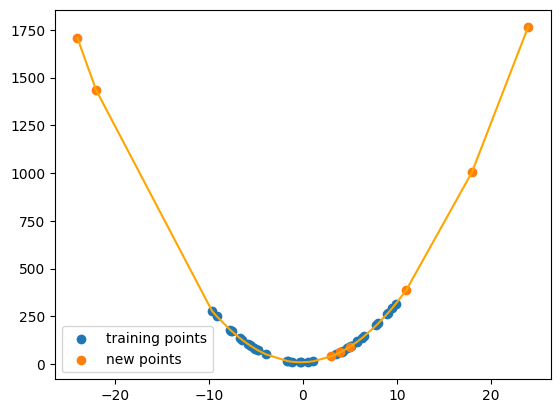

In [17]:
# prediction
with torch.no_grad():
    test_input = torch.tensor([3., 4., 5., 11., 18., 24., -22., -24.])
    test_predicted_output = test_input.clone().apply_(lambda x: generate_data(x, a=A, b=B, c=C))
    
    all_x, _ = torch.sort(torch.cat((input_x, test_input)))
    all_y = model(
        all_x.view(len(all_x), dim_in).to(device)
    ).cpu().flatten()

    print('X: {}', all_x)
    print('Y: {}', all_y)

    plt.plot(all_x, all_y, color='orange')
    plt.scatter(input_x, output_y, label='training points')
    plt.scatter(test_input, test_predicted_output, label='new points')
    
    plt.legend()
    plt.show()

Everything looks perfect!!!

## Does this AI work for another quadratic equation?

As before, this model perfectly works for this specific quadratic equation, but for others it needs to be re-trained